## Data loading

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import regex as re
from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_dependency_ecosystem"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
ftc_df = df[df[ftc_key]]
print(f'{len(df)=}')
print(f'{len(ftc_df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields
                          and field != ftc_key)]

df[independent_fields].describe()


Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'ln(1 + SharedExperiencePullReq

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),...,ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality)
count,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,...,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000
mean,0.715574,0.815452,0.542513,0.327287,0.368079,0.115983,0.313192,0.245195,0.218851,0.078235,...,0.031053,0.060385,0.188145,0.302456,0.063138,0.108372,0.052574,0.096633,0.135202,0.115875
std,0.408035,0.281996,0.473802,0.448171,0.205082,0.067751,0.173881,0.182839,0.199958,0.166624,...,0.102845,0.135882,0.147686,0.193613,0.113169,0.160163,0.113854,0.172460,0.105476,0.104472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.800000,0.000000,0.000000,0.197273,0.075257,0.192585,0.093156,0.000000,0.000000,...,0.000000,0.000000,0.089382,0.155067,0.000000,0.000000,0.000000,0.000000,0.058085,0.037414
50%,0.952381,0.928571,0.833333,0.000000,0.363294,0.075257,0.324045,0.240804,0.182542,0.000000,...,0.000000,0.000000,0.178763,0.310134,0.000000,0.000000,0.000000,0.000000,0.112602,0.089484
75%,1.000000,1.000000,1.000000,0.918919,0.523295,0.119279,0.441411,0.388453,0.373067,0.000000,...,0.000000,0.000000,0.296920,0.450264,0.117002,0.202881,0.000000,0.138630,0.189074,0.165979
max,1.000000,1.000000,1.000000,1.000000,0.980358,0.898782,0.997359,0.744192,0.958786,1.000000,...,1.000000,0.793212,0.854348,0.886728,1.000000,1.000000,1.000000,1.000000,0.870413,0.865460


In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

print(f'{len(train)=}, {len(test)=}')

train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]

test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


len(train)=178335, len(test)=44584


## Model Creation

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score


def calculate_metrics(predicted_labels, true_labels, sample_weights=None):
    return {
        "accuracy": accuracy_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "precision": precision_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "recall": recall_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "f1": f1_score(true_labels, predicted_labels, sample_weight=sample_weights)
    }


def create_model(
    train_predictors: pd.DataFrame,
    train_labels: pd.Series,
    test_predictors: pd.DataFrame,
    test_labels: pd.Series
):
    # Model creation and predictions.
    random_state = seed_counter.get_next()
    print(f'{random_state=}')
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state)

    rf.fit(train_predictors, train_labels)

    predictions = rf.predict(test_predictors)
    predictions = [pred >= 0.5 for pred in predictions]

    # F1 scores.
    conf = confusion_matrix(test_labels, predictions)

    metrics = calculate_metrics(predictions, test_labels)

    print(f'{metrics=}\n')

    # Other metrics.
    print(f'Confusion matrix:\n{conf}\n')
    print("Classification report:")
    print(classification_report(test_labels, predictions))

    return rf, metrics


In [4]:
import regex as re
from python_proj.utils.util import subtract_dict

# Creates full model.
full_rf_model, full_rf_metrics = create_model(
    train_predictors,
    train_dependent,
    test_predictors,
    test_dependent
)

print("Performance metrics full model:")
print(json.dumps(full_rf_metrics, indent=4))


random_state=43
metrics={'accuracy': 0.9443970931275794, 'precision': 0.9525206721792479, 'recall': 0.9869102055173107, 'f1': 0.96941054527955}

Confusion matrix:
[[ 2824  1958]
 [  521 39281]]

Classification report:
              precision    recall  f1-score   support

       False       0.84      0.59      0.69      4782
        True       0.95      0.99      0.97     39802

    accuracy                           0.94     44584
   macro avg       0.90      0.79      0.83     44584
weighted avg       0.94      0.94      0.94     44584

Performance metrics full model:
{
    "accuracy": 0.9443970931275794,
    "precision": 0.9525206721792479,
    "recall": 0.9869102055173107,
    "f1": 0.96941054527955
}


In [5]:

# Creates control model.
control_fields = [field for field in independent_fields
                  if re.match(r'.*Control.*', field)]
print(control_fields)
control_rf_model, control_rf_metrics = create_model(
    train[control_fields],
    train_dependent,
    test[control_fields],
    test_dependent
)

print(json.dumps(control_rf_metrics, indent=4))
print("Comparison between control model and full model (negatives indicate control is better):")
diff = subtract_dict(full_rf_metrics, control_rf_metrics)
print(json.dumps(diff, indent=4))


['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)']
random_state=44
metrics={'accuracy': 0.8883231652610802, 'precision': 0.9196452242655033, 'recall': 0.958670418571931, 'f1': 0.9387524141069956}

Confusion matrix:
[[ 1448  3334]
 [ 1645 38157]]

Classification report:
              precision    recall  f1-score   support

       False       0.47      0.30      0.37      4782
        True       0.92      0.96      0.94     39802

    accuracy                           0.89     44584
   macro avg       0.69      0.63      0.65     44584
weighted avg       0.87      0.89      0.88     44584

{
    "accuracy": 0.8883231652610802,
    "precision": 0.9196452242655033,
    "recall": 0.958670418571931,
    "f1": 0.9387524141069956
}
Comparison b

In [6]:
# Creates measured information model.
non_control_fields = [field for field in independent_fields
                      if field not in control_fields]
non_control_rf_model, non_control_rf_metrics = create_model(
    train[non_control_fields],
    train_dependent,
    test[non_control_fields],
    test_dependent
)

print(json.dumps(non_control_rf_metrics, indent=4))
print("Comparison between non-control model and full model (negatives indicate non-control is better):")
diff = subtract_dict(full_rf_metrics, non_control_rf_metrics)
print(json.dumps(diff, indent=4))


random_state=45
metrics={'accuracy': 0.8976314372869191, 'precision': 0.908983286908078, 'recall': 0.9838450329129189, 'f1': 0.944933761250935}

Confusion matrix:
[[  861  3921]
 [  643 39159]]

Classification report:
              precision    recall  f1-score   support

       False       0.57      0.18      0.27      4782
        True       0.91      0.98      0.94     39802

    accuracy                           0.90     44584
   macro avg       0.74      0.58      0.61     44584
weighted avg       0.87      0.90      0.87     44584

{
    "accuracy": 0.8976314372869191,
    "precision": 0.908983286908078,
    "recall": 0.9838450329129189,
    "f1": 0.944933761250935
}
Comparison between non-control model and full model (negatives indicate non-control is better):
{
    "f1": 0.024476784028614973,
    "recall": 0.0030651726043917638,
    "precision": 0.043537385271169904,
    "accuracy": 0.04676565584066028
}


### Non-control model without intra-project factors

In [7]:
# Creates measured information model.
non_control_fields_wo_intra = [field for field in non_control_fields
                               if not re.match(r'.*Intra.*', field)]
non_control_wo_intra_rf_model, non_control_wo_intra_rf_metrics = create_model(
    train[non_control_fields_wo_intra],
    train_dependent,
    test[non_control_fields_wo_intra],
    test_dependent
)

print(json.dumps(non_control_rf_metrics, indent=4))
print("Comparison between non-control model (without intra-project factors) and full model (negatives indicate non-control is better):")
diff = subtract_dict(full_rf_metrics, non_control_rf_metrics)
print(json.dumps(diff, indent=4))


random_state=46
metrics={'accuracy': 0.892539924636641, 'precision': 0.90831059174772, 'recall': 0.9783930455755993, 'f1': 0.9420501965527669}

Confusion matrix:
[[  851  3931]
 [  860 38942]]

Classification report:
              precision    recall  f1-score   support

       False       0.50      0.18      0.26      4782
        True       0.91      0.98      0.94     39802

    accuracy                           0.89     44584
   macro avg       0.70      0.58      0.60     44584
weighted avg       0.86      0.89      0.87     44584

{
    "accuracy": 0.8976314372869191,
    "precision": 0.908983286908078,
    "recall": 0.9838450329129189,
    "f1": 0.944933761250935
}
Comparison between non-control model (without intra-project factors) and full model (negatives indicate non-control is better):
{
    "f1": 0.024476784028614973,
    "recall": 0.0030651726043917638,
    "precision": 0.043537385271169904,
    "accuracy": 0.04676565584066028
}


## Ablation Study

This is not executed.

In [9]:
from typing import Iterator


def ablation_study(
    train_predictors: pd.DataFrame,
    train_labels: pd.Series,
    test_predictors: pd.DataFrame,
    test_labels: pd.Series,
    evaluated_fields: Iterator[str],
):
    f1_differences_per_feature = {}

    for excluded_feature in evaluated_fields:
        print(f"Creating model without: {excluded_feature}.")
        _train_predictors = train_predictors.drop(excluded_feature, axis=1)
        _test_predictors = test_predictors.drop(excluded_feature, axis=1)

        _, excl_rf_metrics = create_model(
            _train_predictors, train_labels, _test_predictors, test_labels
        )

        diff = subtract_dict(full_rf_metrics, excl_rf_metrics)

        f1_differences_per_feature[excluded_feature] = {
            'Weighted metrics': excl_rf_metrics,
            'Weighted metrics difference': diff,
        }

    return f1_differences_per_feature


# f1_diffs_per_feature = ablation_study(
#     train_predictors, train_dependent,
#     test_predictors, test_dependent,
#     independent_fields
# )

# print("Performance metrics ablation study vs. the full model (negatives suggest the ablation model is better):")
# print(f1_diffs_per_feature)


Outputs results in a csv format

In [10]:
# print(json.dumps(f1_diffs_per_feature))

# fields = ['accuracy', 'precision', 'recall', 'f1', 'accuracy_diff', 'precision_diff', 'recall_diff', 'f1_diff']
# nested_dict= {}

# for feature, scores in f1_diffs_per_feature.items():
#     metrics = scores['Weighted metrics'].values()
#     diff = scores['Weighted metrics difference'].values()
#     vals = [*metrics, *diff]
#     nested_dict[feature] = {}
#     for field, value in zip(fields, vals):
#         nested_dict[feature][field] = value
# ablation_df = pd.DataFrame.from_dict(nested_dict)
# output_path = f'{base_path}/coefs/{file_name}/ablation.csv'
# ablation_df.to_csv(output_path)

Re-calculates performance scores, commparing them with an "all-true prediction" baseline.

In [11]:
vals = test_dependent.value_counts()
class_imbalance = vals[True] / vals[False]
print(f'{class_imbalance=}')
sample_weights = [class_imbalance if not merged else 1 for merged in test_dependent]

predictions = [True] * len(test_dependent)

metrics = calculate_metrics(predictions, test_dependent, sample_weights=sample_weights)
print(f'Weighted base metrics: {metrics}')

metrics = calculate_metrics(predictions, test_dependent)
print(f'Unweighted base metrics: {metrics}')

class_imbalance=8.323295692179004
Weighted base metrics: {'accuracy': 0.5000000000000001, 'precision': 0.4999999999999798, 'recall': 1.0, 'f1': 0.6666666666666488}
Unweighted base metrics: {'accuracy': 0.8927417907769604, 'precision': 0.8927417907769604, 'recall': 1.0, 'f1': 0.9433318322944564}


In [12]:
def calculate_metrics_again(name: str, model: RandomForestRegressor, fields):
    predictions = model.predict(test_predictors[fields])
    predictions = [pred >= 0.5 for pred in predictions]
    metrics = calculate_metrics(predictions, test_dependent, sample_weights)
    print(f'{name}: {metrics}')

calculate_metrics_again("Full", full_rf_model, test_predictors.columns)
calculate_metrics_again("Control", control_rf_model, control_fields)
calculate_metrics_again("Non-control", non_control_rf_model, non_control_fields)
calculate_metrics_again("Non-control no intra", non_control_wo_intra_rf_model, non_control_fields_wo_intra)

Full: {'accuracy': 0.788729046715159, 'precision': 0.7067722990481018, 'recall': 0.9869102055173107, 'f1': 0.8236736141836494}
Control: {'accuracy': 0.6307362966970906, 'precision': 0.5789533208276681, 'recall': 0.958670418571931, 'f1': 0.7219261880389446}
Non-control: {'accuracy': 0.5819476105593453, 'precision': 0.5454306712317089, 'recall': 0.9838450329129189, 'f1': 0.7017953077202965}
Non-control no intra: {'accuracy': 0.5781760292704429, 'precision': 0.5434206573828749, 'recall': 0.9783930455755993, 'f1': 0.6987438619745865}


/tmp/ipykernel_177568/2867122124.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


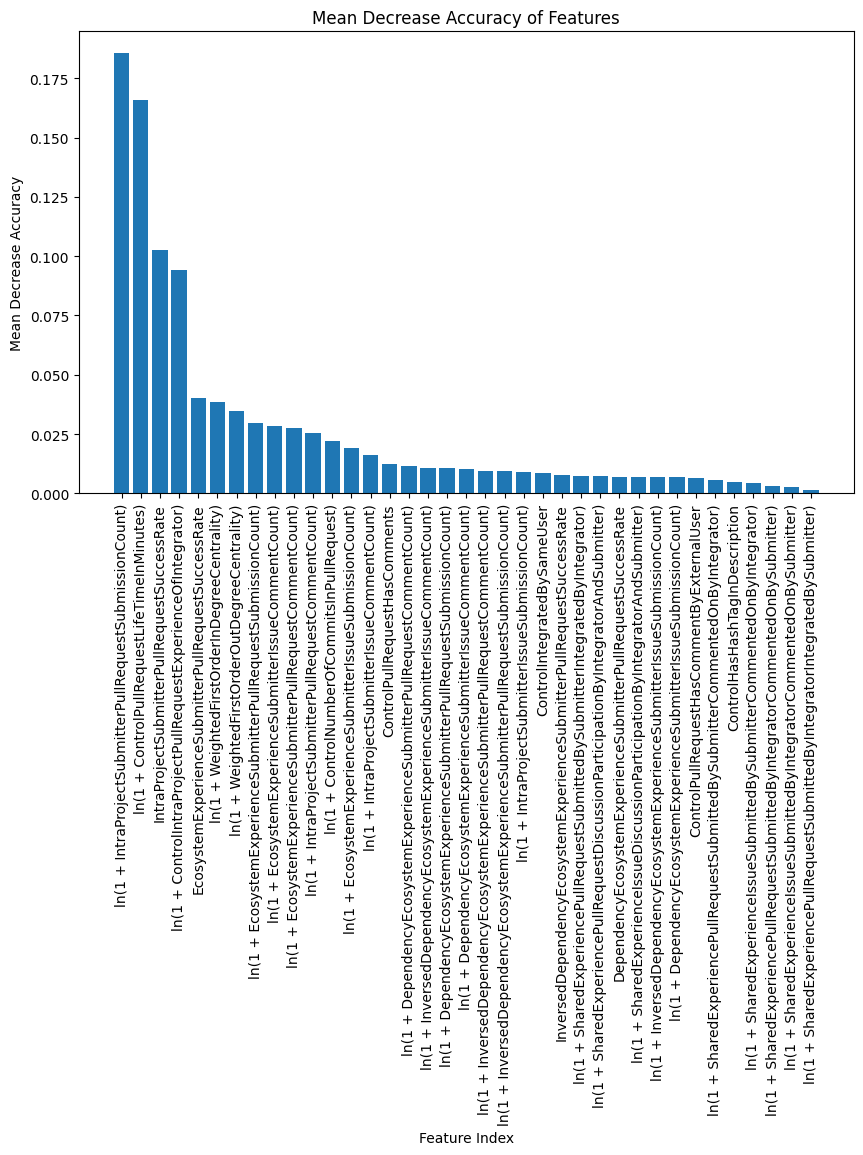

ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.1855
ln(1 + ControlPullRequestLifeTimeInMinutes): 0.1659
IntraProjectSubmitterPullRequestSuccessRate: 0.1024
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.0942
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.0401
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.0385
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.0348
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.0298
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.0286
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.0276
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.0255
ln(1 + ControlNumberOfCommitsInPullRequest): 0.0221
ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount): 0.0192
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.0161
ControlPullRequestHasComments: 0.0123
ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount): 0.0117
ln(1 + InversedDependencyEcosystemExperienceSub

In [13]:
feature_importances = full_rf_model.feature_importances_    

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease Accuracy')
plt.title('Mean Decrease Accuracy of Features')
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

for field, importance in zip(ordererd_columns, sorted_importances):
    print(f'{field}: {importance:.04f}')


## Partial Dependence Plots

In [14]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt


def create_partial_dependence_plots(
        rf_model: RandomForestRegressor,
        used_predictors: pd.DataFrame,
        used_labels: pd.Series,
        model_name: str = ""):

    # Collective partial dependence plot.
    PartialDependenceDisplay.from_estimator(
        rf_model, used_predictors, used_predictors.columns)

    fig = plt.gcf()
    axs = fig.axes

    lines = []
    for ax in axs:
        __lines = list([(line.get_xdata(), line.get_ydata())
                        for line in ax.lines])
        lines.extend(__lines)

    for (x, y), label in zip(lines, used_predictors.columns):
        plt.clf()
        plt.plot(x, y, linestyle='-', color='#e69d00')
        plt.xlabel(label)
        plt.ylabel('Partial Dependence')
        plt.tight_layout()
        output_path = f"{figure_base_path}/partial-dependence/{model_name}/{label}.png"
        safe_save_fig(output_path)


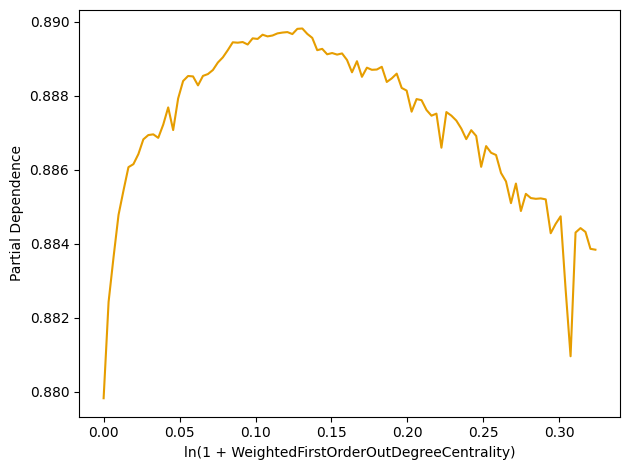

In [15]:
create_partial_dependence_plots(
    full_rf_model,
    test_predictors,
    test_dependent,
    model_name="full_model"
)
